In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time 

import numpy as np
import scipy as sc
import pandas as pd
import torch

import gb1
import models
from utils import str2onehot

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

MODEL_PATH = '/data/wongfanc/gb1-models/'

2024-05-21 02:32:04.370206: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 02:32:04.370239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 02:32:04.371389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 02:32:04.377858: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 02:32:06.070968: W tensorflow/comp

# simulated Gaussian data

In [32]:
# validity of max-z CIs
d = 10
alpha = 0.1
n_trial = 1000

A = np.random.rand(d, d)
Sigma_dxd = np.dot(A, A.transpose())
sigma_d = np.sqrt(np.diag(Sigma_dxd))
theta_d = np.random.rand(d)

coverage = 0
for i in range(n_trial):
    
    thetahat_d = sc.stats.multivariate_normal.rvs(
        mean=theta_d, cov=Sigma_dxd, size=1
    )

    z_txd = sc.stats.multivariate_normal.rvs(
        mean=None, cov=Sigma_dxd, size=1000
    )
    maxz_t = np.max(np.abs(z_txd) / sigma_d, axis=1)

    qa = np.quantile(maxz_t, 1 - alpha)
    ca_dx2 = np.array(list(zip(thetahat_d - qa * sigma_d, thetahat_d + qa * sigma_d)))
    
    if np.all(theta_d >= ca_dx2[:, 0]) and np.all(theta_d <= ca_dx2[:, 1]):
        coverage += 1
        
coverage /= n_trial
print(coverage)

# plt.scatter(range(d), theta_d);
# for i, ca_2 in enumerate(ca_dx2):
#     plt.plot([i, i], ca_2, c='orange');

0.893


In [2]:
# validity of max-z LBs
d = 10
alpha = 0.1
n_trial = 1000

A = np.random.rand(d, d)
Sigma_dxd = np.dot(A, A.transpose())
sigma_d = np.sqrt(np.diag(Sigma_dxd))
theta_d = np.random.rand(d)

coverage = 0
for i in range(n_trial):
    
    thetahat_d = sc.stats.multivariate_normal.rvs(
        mean=theta_d, cov=Sigma_dxd, size=1
    )

    z_txd = sc.stats.multivariate_normal.rvs(
        mean=None, cov=Sigma_dxd, size=1000
    )
    maxz_t = np.max(z_txd / sigma_d, axis=1)

    qa = np.quantile(maxz_t, 1 - alpha)
    lb_d = thetahat_d - qa * sigma_d
    
    if np.all(theta_d >= lb_d):
        coverage += 1
        
coverage /= n_trial
print(coverage)

# plt.scatter(range(d), theta_d);
# for i, ca_2 in enumerate(ca_dx2):
#     plt.plot([i, i], ca_2, c='orange');

0.895


## FWER of selection using 1-sided max-z p-values

In [326]:
# known Sigma
d = 10
alphas = np.arange(0.05, 1, 0.05)
n_trial = 10000

A = np.random.rand(d, d)
Sigma_dxd = np.dot(A, A.transpose())
sigma_d = np.sqrt(np.diag(Sigma_dxd))
theta_d = np.random.rand(d)
tau = np.quantile(theta_d, 0.5)

z_txd = sc.stats.multivariate_normal.rvs(
    mean=None, cov=Sigma_dxd, size=10000
)
maxz_t = np.max(z_txd / sigma_d[None, :], axis=1)

errdisc_ax4 = np.zeros((alphas.size, 4))
for a, alpha in enumerate(alphas):
    alpha = round(alpha, 4)
    qa = np.quantile(maxz_t, 1 - alpha)
    
    for i in range(n_trial):

        thetahat_d = sc.stats.multivariate_normal.rvs(
            mean=theta_d, cov=Sigma_dxd, size=1
        )
        score_d = (thetahat_d - tau) / sigma_d

        # ===== selection =====
        
        # max-z
        # idx = np.where(score_d >= qa)[0]
        
        # equivalent:
        p_d = 1 - np.mean(score_d[:, None] >= maxz_t[None, :], axis=1)
        idx = np.where(p_d <= alpha)[0]
        
        if idx.size:
            errdisc_ax4[a, 1] += 1
            if np.any(theta_d[idx] < tau):
                errdisc_ax4[a, 0] += 1

        # bonferroni
        p_d = 1 - sc.stats.norm.cdf(score_d)
        idx = np.where(p_d <= alpha / d)[0]
        if idx.size:
            errdisc_ax4[a, 3] += 1
            if np.any(theta_d[idx] < tau):
                errdisc_ax4[a, 2] += 1


    errdisc_ax4[a] /= n_trial
    print(alpha)
    

0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


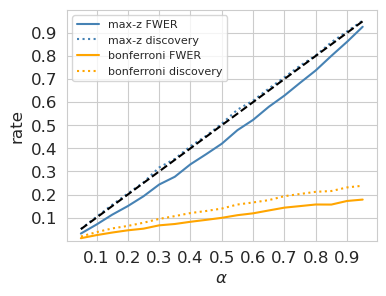

In [327]:
plt.figure(figsize=(4, 3))
plt.plot(alphas, errdisc_ax4[:, 0], label='max-z FWER', c='steelblue')
plt.plot(alphas, errdisc_ax4[:, 1], label='max-z discovery', c='steelblue', linestyle=':')
plt.plot(alphas, errdisc_ax4[:, 2], label='bonferroni FWER', c='orange')
plt.plot(alphas, errdisc_ax4[:, 3], label='bonferroni discovery', c='orange', linestyle=':')
plt.plot(alphas, alphas, '--k');
plt.ylim([0, 1]);
plt.legend(fontsize=8);
plt.xticks(np.arange(0.1, 1, 0.1));
plt.yticks(np.arange(0.1, 1, 0.1));
plt.xlabel(r'$\alpha$');
plt.ylabel('rate');

In [224]:
# estimated Sigma
d = 10
alphas = np.arange(0.1, 1, 0.1)
n_sample = 10
n_trial = 10000

A = np.random.rand(d, d)
Sigma_dxd = np.dot(A, A.transpose())
theta_d = np.random.rand(d)
tau = np.quantile(theta_d, 0.5)

# simulating max-z statistics
thetahat_sxd = sc.stats.multivariate_normal.rvs(
    mean=theta_d, cov=Sigma_dxd, size=n_sample
)
Sigmahat_dxd = np.cov(thetahat_sxd.T)
z_txd = sc.stats.multivariate_normal.rvs(
    mean=None, cov=Sigmahat_dxd, size=10000
)
sigmahat_d = np.sqrt(np.diag(Sigmahat_dxd))
maxz_t = np.max(z_txd / sigmahat_d[None, :], axis=1)

errdisc_ax4 = np.zeros((alphas.size, 4))
for a, alpha in enumerate(alphas):
    alpha = round(alpha, 4)
    qa = np.quantile(maxz_t, 1 - alpha)
    
    for i in range(n_trial):

        thetahat_d = sc.stats.multivariate_normal.rvs(
            mean=theta_d, cov=Sigma_dxd, size=1
        )
        score_d = (thetahat_d - tau) / sigmahat_d

        # selection
        idx = np.where(score_d >= qa)[0]
        if idx.size:
            errdisc_ax4[a, 1] += 1
            if np.any(theta_d[idx] < tau):
                errdisc_ax4[a, 0] += 1

        # bonferroni
        p_d = 1 - sc.stats.norm.cdf(score_d)
        idx = np.where(p_d <= alpha / d)[0]
        if idx.size:
            errdisc_ax4[a, 3] += 1
            if np.any(theta_d[idx] < tau):
                errdisc_ax4[a, 2] += 1


    errdisc_ax4[a] /= n_trial
    print(alpha)
    

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


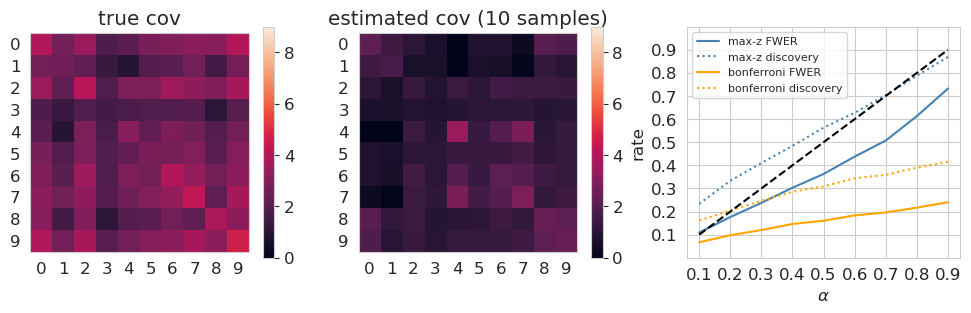

In [225]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(Sigma_dxd, vmin=0, vmax=9)
plt.grid(None)
plt.title('true cov');
plt.colorbar()
plt.xticks(range(d))
plt.yticks(range(d))

plt.subplot(132)
plt.imshow(Sigmahat_dxd, vmin=0, vmax=9)
plt.grid(None)
plt.xticks(range(d))
plt.yticks(range(d))
plt.title(f'estimated cov ({n_sample} samples)');

plt.colorbar()

plt.subplot(133)
plt.plot(alphas, errdisc_ax4[:, 0], label='max-z FWER', c='steelblue')
plt.plot(alphas, errdisc_ax4[:, 1], label='max-z discovery', c='steelblue', linestyle=':')
plt.plot(alphas, errdisc_ax4[:, 2], label='bonferroni FWER', c='orange')
plt.plot(alphas, errdisc_ax4[:, 3], label='bonferroni discovery', c='orange', linestyle=':')
plt.plot(alphas, alphas, '--k');
plt.ylim([0, 1]);
plt.legend(fontsize=8);
plt.xticks(np.arange(0.1, 1, 0.1));
plt.yticks(np.arange(0.1, 1, 0.1));
plt.xlabel(r'$\alpha$');
plt.ylabel('rate');

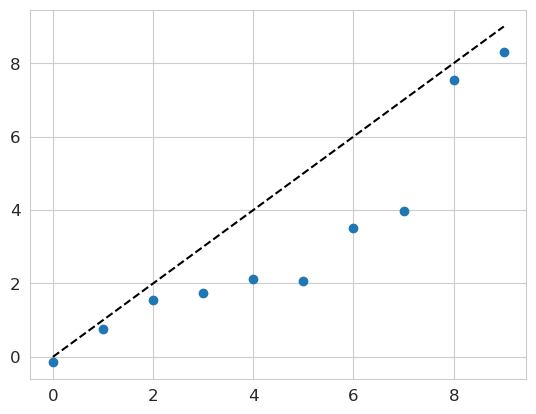

In [313]:
# testing out snippet from following cell...
# calibration data from fat Laplace
n_cal = 100
ycal_n = sc.stats.laplace.rvs(loc=0, scale=2, size=n_cal)

# density ratios w.r.t Laplace distributions centered at 0, 1, ... d - 1
dr_dxn = np.zeros([d, n_cal])
for loc in range(d):
    dr_dxn[loc] = sc.stats.laplace.pdf(ycal_n, loc=loc, scale=1)
dr_dxn /= sc.stats.laplace.pdf(ycal_n, loc=0, scale=2)[None, :]

# IW estimates
thetahat_d = np.mean(ycal_n[None, :] * dr_dxn, axis=1)
plt.scatter(range(d), thetahat_d)
plt.plot(range(d), range(d), '--k')

In [316]:
# estimated CLT Sigma
d = 10
tau = 8
n_cal = 100
n_trial = 100
n_boot = 10000
alphas = np.arange(0.5, 1, 0.1)

errdisc_ax4 = np.zeros((alphas.size, 4))
t0 = time()
for i in range(n_trial):
    
    # calibration data from fat Laplace
    ycal_n = sc.stats.laplace.rvs(loc=0, scale=2, size=n_cal)

    # density ratios w.r.t Laplace distributions centered at 0, 1, ... d - 1
    dr_dxn = np.zeros([d, n_cal])
    for loc in range(d):
        dr_dxn[loc] = sc.stats.laplace.pdf(ycal_n, loc=loc, scale=1)
    dr_dxn /= sc.stats.laplace.pdf(ycal_n, loc=0, scale=2)[None, :]

    # IW estimates
    thetahat_d = np.mean(ycal_n[None, :] * dr_dxn, axis=1)

    # bootstrap to estimate Sigma of IW estimates
    thetahatboot_bxd = np.zeros([n_boot, d])
    for j in range(n_boot):
        idx = np.random.choice(n_cal, size=n_cal, replace=True)
        thetahatboot_bxd[j] = np.mean(ycal_n[None, idx] * dr_dxn[:, idx], axis=1)

    # simulating max-z statistics 
    Sigmahat_dxd = np.cov(thetahatboot_bxd.T)
    z_txd = sc.stats.multivariate_normal.rvs(
        mean=None, cov=Sigmahat_dxd, size=10000
    )
    sigmahat_d = np.sqrt(np.diag(Sigmahat_dxd))
    maxz_t = np.max(z_txd / sigmahat_d[None, :], axis=1)
    
    # ===== selection =====

    score_d = (thetahat_d - tau) / sigmahat_d
    
    for a, alpha in enumerate(alphas):
        alpha = round(alpha, 4)
        qa = np.quantile(maxz_t, 1 - alpha)

        # max-z
        idx = np.where(score_d >= qa)[0]
        if idx.size:
            errdisc_ax4[a, 1] += 1
            if np.any(idx < tau):
                errdisc_ax4[a, 0] += 1

        # bonferroni
        p_d = 1 - sc.stats.norm.cdf(score_d)
        idx = np.where(p_d <= alpha / d)[0]
        if idx.size:
            errdisc_ax4[a, 3] += 1
            if np.any(idx < tau):
                errdisc_ax4[a, 2] += 1
    if (i + 1) % 10 == 0:
        print(f'done with {i + 1} / {n_trial} trials ({int(time() - t0)} s)')

errdisc_ax4 /= n_trial
    

done with 10 / 100 trials (5 s)
done with 20 / 100 trials (10 s)
done with 30 / 100 trials (15 s)
done with 40 / 100 trials (21 s)
done with 50 / 100 trials (26 s)
done with 60 / 100 trials (31 s)
done with 70 / 100 trials (37 s)
done with 80 / 100 trials (42 s)
done with 90 / 100 trials (47 s)
done with 100 / 100 trials (52 s)


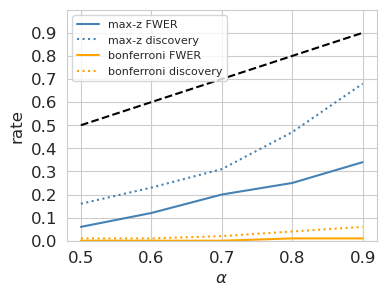

In [317]:
plt.figure(figsize=(4, 3))
plt.plot(alphas, errdisc_ax4[:, 0], label='max-z FWER', c='steelblue')
plt.plot(alphas, errdisc_ax4[:, 1], label='max-z discovery', c='steelblue', linestyle=':')
plt.plot(alphas, errdisc_ax4[:, 2], label='bonferroni FWER', c='orange')
plt.plot(alphas, errdisc_ax4[:, 3], label='bonferroni discovery', c='orange', linestyle=':')
plt.plot(alphas, alphas, '--k');
plt.ylim([0, 1]);
plt.legend(fontsize=8);
plt.xticks(alphas);
plt.yticks(np.arange(0, 1, 0.1));
plt.xlabel(r'$\alpha$');
plt.ylabel('rate');

# selection of GB1 libraries!

In [9]:
# load model
reload(models)
reload(gb1)

n_hidden = 10
n_model = 3
device = torch.device(0)

model = models.EnrichmentFeedForward(
    4,
    gb1.AA,
    n_hidden=n_hidden,
    n_model=n_model,
    device=device
)
model.load('gb1-h10-5k-030123')

# load design distributions
temperatures = np.arange(0.2, 0.701, 0.05)
temp2theta = {
    round(temp, 4): np.load(MODEL_PATH + 'gb1-h10-5k-t{:.4f}-030123.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}

# true means of design distributions
temp2mean = gb1.get_true_mean_label_from_theta(temp2theta) 

In [4]:
from pandas import DataFrame
from statsmodels.stats.weightstats import _zstat_generic


In [10]:
target_values = np.arange(0.0, 1.51, 0.1)
n_design = 1000000
n_trial = 20
save_path = '/data/wongfanc/gb1-results'
design_samples_fname_prefix = 'gb1-h10-5k-030123-samples'

temperatures = list(temp2theta.keys())
target_values = np.array([round(v, 4) for v in target_values])
imp_selected_column_names = ['imp_pval_temp{:.4f}'.format(temp) for temp in temperatures]
pp_selected_column_names = ['tr{}_pp_pval_temp{:.4f}'.format(i, temp) for i in range(n_trial) for temp in temperatures]
df = DataFrame(index=target_values, columns=imp_selected_column_names + pp_selected_column_names)

predictor = model
print('Range of provided target values: [{:.3f}, {:.3f}].\n'.format(np.min(target_values), np.max(target_values)))

# ===== imputation =====
t0 = time()
imputed_mean_se_tx2 = np.zeros([len(temperatures), 2])
for t, (temp, theta_lxa) in enumerate(temp2theta.items()):

    # sampling design sequences is the bottleneck for computation
    design_samples_fname = os.path.join(save_path, '{}-t{:.4f}.npz'.format(design_samples_fname_prefix, temp))
    d = np.load(design_samples_fname)
    designohe_nxlxa = d['designohe_nxlxa']
    if designohe_nxlxa.shape[0] != n_design:
        raise ValueError('Loaded {} != n_design = {} design sequences from {}.'.format(
            designohe_nxlxa.shape[0], n_design, design_samples_fname
        ))
    print('Loaded {} design sequences from {}.'.format(n_design, design_samples_fname))

    # predictions for unlabeled design sequences
    preddesign_n = predictor.predict(designohe_nxlxa)
    imputed_mean = np.mean(preddesign_n)
    imputed_se = np.std(preddesign_n) / np.sqrt(preddesign_n.size)
    imputed_mean_se_tx2[t] = imputed_mean, imputed_se

    for target_val in target_values:

        # imputation hypothesis test. only run one trial since N so large
        imp_pval = _zstat_generic(
            imputed_mean,
            0,
            imputed_se,
            alternative='larger',
            diff=target_val
        )[1]
        df.loc[target_val]['imp_pval_temp{:.4f}'.format(temp)] = imp_pval

Range of provided target values: [0.000, 1.500].

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2000.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2500.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.3000.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.3500.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.4000.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.4500.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.5000.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.5500.npz.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.6000.npz.
Loaded 1000000 design s

In [ ]:
# HERE: make bootstrap faster
# --- bootstrap to estimate covariance of all temps' PP point estimates -----
bootidx_bxn = np.random.choice(n_cal, size=(n_bootstrap, n_cal), replace=True)
thetahatboot_txb = np.zeros([len(temperatures), n_bootstrap])
for b, bootidx_n in enumerate(bootidx_bxn):
    caldrboot_txn = caldr_txn[:, bootidx_n]
    if self_normalize_weights:
        caldrboot_txn = n_cal * caldrboot_txn / np.sum(caldrboot_txn, axis=1, keepdims=True)
    rectboot_txn = caldrboot_txn * (ycal_n - predcal_n)[None, :]
    thetahatboot_txb[:, b] = imputed_mean_se_tx2[:, 0] + np.mean(rectboot_txn, axis=1)

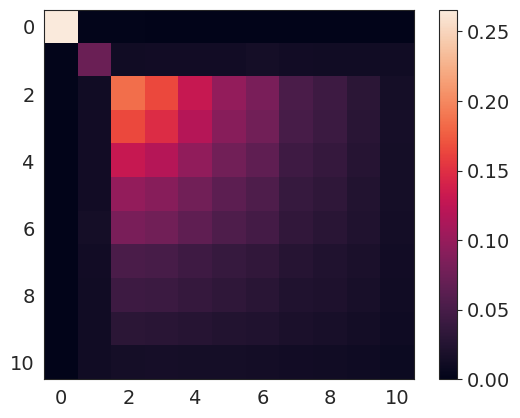

In [17]:
plt.imshow(Sigmahat_txt);
plt.colorbar();

In [13]:
# HERE debug
n_cal = 5000
self_normalize_weights = True
n_bootstrap = 100000
alpha = 0.1

# ===== PP =====
t0 = time()
for i in range(n_trial):

    # ----- sample labeled calibration data from NNK -----
    _, calohe_nxlxa, calseq_n = gb1.sample_ohe_from_nuc_distribution(
        gb1.PNUC_NNK_LXA, n_cal, normalize=False, reject_stop_codon=True
    )
    ycal_n = np.array([gb1.SEQ2YVAR[seq][0] for seq in calseq_n])

    # predictions for calibration sequences
    predcal_n = predictor.predict(calohe_nxlxa)
    callogptrain_n = gb1.get_nostop_loglikelihood(calohe_nxlxa, gb1.PAA_NNK_LXA)

    # ---- PP point estimate for each temperature -----
    thetahat_t = np.zeros([len(temperatures)])
    caldr_txn = np.zeros([len(temperatures), n_cal])
    for t, (temp, theta_lxa) in enumerate(temp2theta.items()):

        # density ratios on labeled calibration sequences
        caldr_n = gb1.get_density_ratios(calohe_nxlxa, theta_lxa, logptrain_n=callogptrain_n)
        caldr_txn[t] = caldr_n
        if self_normalize_weights:
            caldr_n = caldr_n / np.sum(caldr_n) * caldr_n.size

        # rectifier sample mean and standard error
        rect_n = caldr_n * (ycal_n - predcal_n)
        rectifier_mean = np.mean(rect_n)

        # PP point estimate
        thetahat_t[t] = imputed_mean_se_tx2[t, 0] + rectifier_mean

    # --- bootstrap to estimate covariance of all temps' PP point estimates -----
    bootidx_bxn = np.random.choice(n_cal, size=(n_bootstrap, n_cal), replace=True)
    thetahatboot_txb = np.zeros([len(temperatures), n_bootstrap])
    for b, bootidx_n in enumerate(bootidx_bxn):
        caldrboot_txn = caldr_txn[:, bootidx_n]
        if self_normalize_weights:
            caldrboot_txn = n_cal * caldrboot_txn / np.sum(caldrboot_txn, axis=1, keepdims=True)
        rectboot_txn = caldrboot_txn * (ycal_n - predcal_n)[None, :]
        thetahatboot_txb[:, b] = imputed_mean_se_tx2[:, 0] + np.mean(rectboot_txn, axis=1)

    # ----- simulate max-t statistics -----
    Sigmahat_txt = np.cov(thetahatboot_txb)
    z_xt = sc.stats.multivariate_normal.rvs(mean=None, cov=Sigmahat_txt, size=100000)
    sigmahat_t = np.sqrt(np.diag(Sigmahat_txt))
    maxt_ = np.max(z_xt / sigmahat_t[None, :], axis=1)
    qa = np.quantile(maxt_, 1 - alpha)

    # ----- compute prediction-powered max-t p-values -----
    for target_val in target_values:
        score_t = (thetahat_t - target_val) / sigmahat_t
#         cdf_t = np.mean(score_t[:, None] >= maxt_[None, :], axis=1)
#         p_t = 1 - cdf_t
#             for t, te72mp in enumerate(temperatures):
#                 df.loc[target_val]['tr{}_pp_pval_temp{:.4f}'.format(i, temp)] = p_t[t]

        selected_idx = np.where(score_t >= qa)[0]
        for t, temp in enumerate(temperatures):
            if t in selected_idx:
                df.loc[target_val]['tr{}_pp_pval_temp{:.4f}'.format(i, temp)] = 0
            else:
                df.loc[target_val]['tr{}_pp_pval_temp{:.4f}'.format(i, temp)] = 1

    # ----- print and save progress -----
    print(f'Done with {i + 1} / {n_trial} trials ({int(time() - t0)} s).')

Done with 1 / 20 trials (72 s).
Done with 2 / 20 trials (145 s).
Done with 3 / 20 trials (219 s).
Done with 4 / 20 trials (292 s).
Done with 5 / 20 trials (365 s).
Done with 6 / 20 trials (438 s).
Done with 7 / 20 trials (511 s).
Done with 8 / 20 trials (584 s).
Done with 9 / 20 trials (657 s).
Done with 10 / 20 trials (731 s).
Done with 11 / 20 trials (804 s).
Done with 12 / 20 trials (876 s).
Done with 13 / 20 trials (949 s).
Done with 14 / 20 trials (1022 s).
Done with 15 / 20 trials (1095 s).
Done with 16 / 20 trials (1168 s).
Done with 17 / 20 trials (1241 s).
Done with 18 / 20 trials (1314 s).
Done with 19 / 20 trials (1386 s).
Done with 20 / 20 trials (1459 s).


In [14]:
# plottable quantities
alpha_threshold = 0.1

impworst_v = []
imperr_v = []
impmag_v = []
impdisc_v = []

ppworst_v = []
pperr_v = []
ppmag_v = []
ppdisc_v = []

val2imptemprange = {}
val2pptemprange = {}

t0 = time()
for v, val in enumerate(target_values):
    
    val = round(val, 4)
    
    # ----- imputation -----
    imp_selected_minmax_t = []
    
    imp_selected = [temp for temp in temperatures if df.loc[val]['imp_pval_temp{:.4f}'.format(temp)] < alpha_threshold]
    imp_achieved = [temp2mean[round(t, 4)] for t in imp_selected] 
    if len(imp_selected):
        impworst_v.append(np.min(imp_achieved))
        err = np.min(imp_achieved) < val
        imperr_v.append(err.astype(float))
        impmag_v.append(np.fmax(val - np.min(imp_achieved), 0))
        impdisc_v.append(True)
        val2imptemprange[round(val, 4)] = [np.min(imp_selected), np.max(imp_selected)]
        
    else:
        impworst_v.append(np.nan)
        imperr_v.append(0.)
        impmag_v.append(0)
        impdisc_v.append(False)
        val2imptemprange[round(val, 4)] = []
        
    # ----- PP -----
    pp_worst_t = []
    ppmag_t = []
    pptemprange_t = []
    
    for t in range(n_trial):
        pp_selected = [temp for temp in temperatures if df.loc[val]['tr{}_pp_pval_temp{:.4f}'.format(t, temp)] < alpha_threshold]
        pp_achieved = pp_true_values = [temp2mean[round(t, 4)] for t in pp_selected]
        if len(pp_selected):
            pp_worst_t.append(np.min(pp_achieved))
            ppmag_t.append(np.fmax(val - np.min(pp_achieved), 0))
            pptemprange_t.append([np.min(pp_selected), np.max(pp_selected)])
            # if no discovery/selection, no worst achieved value
        else:
            pptemprange_t.append([])
            
    ppworst_v.append(pp_worst_t)
    pperr_v.append(np.sum(np.array(pp_worst_t) < val) / n_trial) 
    ppmag_v.append(np.sum(ppmag_t) / n_trial)
    ppdisc_v.append(len(pp_worst_t) / n_trial)
    val2pptemprange[round(val, 4)] = pptemprange_t

print('{} s'.format(int(time() - t0)))
    

0 s


/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


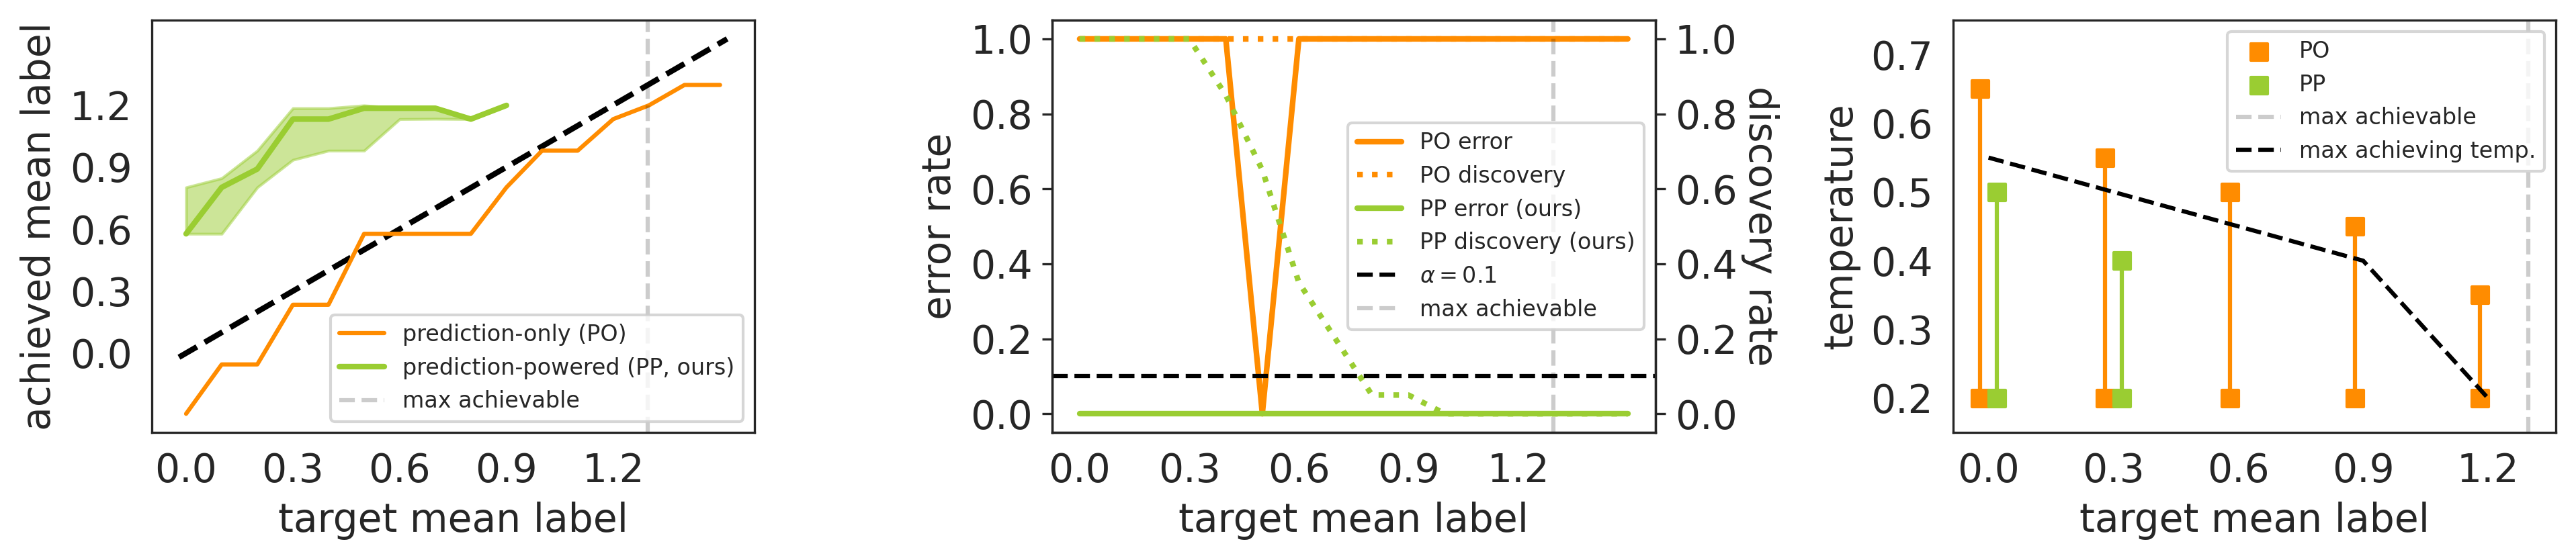

In [15]:
# plot results
run_exceedance = False
plt.rcParams["font.size"] = 14
sns.set_style('white')
fig, axs = plt.subplots(1, 3, figsize=(13, 3), dpi=300)

alpha = 0.1
imp_color = 'darkorange'
pp_color = 'yellowgreen'
q_low = 0.25
q_high = 0.75
trial_idx = 0 # 25, 451 
offset = 0.02
example_targets = np.arange(np.min(target_values), np.max(target_values), 0.3)

axs[0].plot(
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    '--k', linewidth=2
);
axs[0].plot(
    target_values, impworst_v, c=imp_color, label='prediction-only (PO)', linewidth=1.5,
)
axs[0].plot(
    target_values, [np.median(worst) for worst in ppworst_v],
    c=pp_color, label='prediction-powered (PP, ours)', linewidth=2,
)
axs[0].fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5, # label='PP ({:.2f} - {:.2f})'.format(q_low, q_high)
)
max_achievable = np.max(list(temp2exceedance.values())) if run_exceedance else np.max(list(temp2mean.values()))
axs[0].axvline(max_achievable, linestyle='--', color='k', alpha=0.2, label='max achievable')
axs[0].legend(fontsize=8)
axs[0].set_xlabel('target exceedance' if run_exceedance else 'target mean label');
axs[0].set_ylabel('achieved exceedance' if run_exceedance else 'achieved mean label');
axs[0].set_xticks(np.arange(np.min(target_values), np.max(target_values), 0.3))
axs[0].set_yticks(np.arange(np.min(target_values), np.max(target_values), 0.3))

axs[1].set_ylabel('error rate');
axs[1].set_xlabel('target exceedance' if run_exceedance else 'target mean label');
axs[1].set_ylim([-0.05, 1.05])
axs[1].set_xticks(np.arange(np.min(target_values), np.max(target_values), 0.3))
axs[1].set_yticks(np.arange(0, 1.1, 0.2))

disc_ax = axs[1].twinx()
disc_ax.plot(target_values, imperr_v, c=imp_color, linewidth=2, label='PO error');
disc_ax.plot(target_values, impdisc_v, ':', c=imp_color, linewidth=2, label='PO discovery');
disc_ax.plot(target_values, pperr_v, c=pp_color, linewidth=2, label='PP error (ours)');
disc_ax.plot(target_values, ppdisc_v, ':', c=pp_color, linewidth=2, label='PP discovery (ours)');
disc_ax.axhline(alpha, linestyle='--', color='k', linewidth=1.5, label=r'$\alpha = {}$'.format(alpha));
disc_ax.axvline(max_achievable, linestyle='--', color='k', alpha=0.2, label='max achievable')
disc_ax.legend(fontsize=8)
disc_ax.set_ylabel('discovery rate', rotation=270, labelpad=15);
disc_ax.set_yticks(np.arange(0, 1.1, 0.2))

maxtemp_v = []
for v, val in enumerate(example_targets):
    val = round(val, 4)
    if run_exceedance:
        temps = [t for t in temperatures if temp2exceedance[round(t, 4)] >= val]
        maxtemp_v.append(np.max(temps) if len(temps) else np.nan)
    else:
        maxtemp_v.append(np.max([t for t in temperatures if temp2mean[round(t, 4)] >= val]))
    axs[2].plot([val - offset, val - offset], val2imptemprange[val], c=imp_color)
    axs[2].scatter(
        [val - offset, val - offset], val2imptemprange[val],
        marker='s', c=imp_color, label='PO' if v == 0 else None
    )
    if len(val2pptemprange[val][trial_idx]):
        axs[2].plot([val + offset, val + offset], val2pptemprange[val][trial_idx], c=pp_color)
        axs[2].scatter(
            [val + offset, val + offset], val2pptemprange[val][trial_idx],
            marker='s', c=pp_color, label='PP' if v == 0 else None
        )
axs[2].axvline(max_achievable, linestyle='--', color='k', alpha=0.2, label='max achievable')
axs[2].plot(example_targets, maxtemp_v, '--k', linewidth=1.5, label='max achieving temp.')
axs[2].legend(fontsize=8)
axs[2].set_ylim([0.15, 0.75])
axs[2].set_ylabel('temperature');
axs[2].set_xlabel('target exceedance' if run_exceedance else 'target mean label')
axs[2].set_xticks(np.arange(np.min(target_values), np.max(target_values), 0.3))
axs[2].set_yticks(np.arange(0.2, 0.71, 0.1))

fig.tight_layout()

In [ ]:
reload(models)
reload(gb1)

target_values = np.arange(0.0, 1.51, 0.05) # np.arange(0.0, 1.01, 0.02)
n_cal = 5000
n_trial = 100
n_design = 1000000
results_csv_fname = 'gb1-maxt-ncal{}{}-{}052024.csv'.format(
    n_cal, '_exceed{}'.format(threshold) if run_exceedance else '',
    f'tr{n_train_lr}_' if run_exceedance else ''
)
save_design_samples = False
load_design_samples = True

design_samples_fname_prefix = 'gb1-h10-5k-030123-samples'

df = gb1.run_temperature_selection_experiments_maxt(
    model,
    temp2theta,
    target_values,
    n_cal=n_cal,
    n_design=n_design,
    n_trial=n_trial,
    results_csv_fname=results_csv_fname,
    design_samples_fname_prefix=design_samples_fname_prefix,
)